# 1. Preparation

## 1.1. Import Libraries

In [3]:
import os
import re
import string
import warnings
warnings.simplefilter("ignore")

import lightgbm as lgb
import nltk
import numpy as np
import optuna
import pandas as pd
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from keras.layers import add, concatenate
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from optuna.integration import KerasPruningCallback
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split as tts
from sklearn.utils.class_weight import compute_class_weight as ccw
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    BatchNormalization,
    Dense,
    Dropout,
    Flatten,
    Input,
    LeakyReLU,
    Rescaling,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed, to_categorical

pd.options.display.max_columns=100
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.2. Fetching Data

In [4]:
seed = 0
np.random.seed(seed)
set_random_seed(seed)

train_df = pd.read_csv("../input/train.csv", index_col="text_id")
X_train = train_df.full_text
cols = [col for col in train_df.columns if col != "full_text"]
y_train = train_df[cols]
X_test = pd.read_csv("../input/test.csv", index_col="text_id").full_text
X_test_idx = X_test.index

## 1.3. Custom Fanctions

memo
encoding, onebyone_wrapper, kfold, oversampling, building_model, check_results
optuna, optunaresult, predict

In [88]:
@tf.autograph.experimental.do_not_convert
def MCRMSE(y_true, y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))

In [160]:
class BuildModel:
    
    def __init__(self, X_train = X_train, y_train = y_train, X_test = X_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train

    def execution(self, params):
        X_train_enc, X_test = self.encodingX(params["pca_components"])
        preds = []; evals = []
        X_trains, X_vals, y_trains, y_vals = self.kfold(X_train_enc, self.y_train, n_splits=params["valid_splits"])
        for X_train, X_val, y_train, y_val in zip(X_trains, X_vals, y_trains, y_vals):
            X_train, y_train = self.oversampling(X_train, y_train)
            model, evaluation = self.modeling(X_train, y_train, params, X_val, y_val)
            preds += [pd.DataFrame(model.predict(X_val), index=X_val.index, columns=[y_train.name])]
            evals += [evaluation]
        return np.mean(evals), pd.concat(preds, axis=0)
    
    def finalize(self, y_train, params):
        X_train_enc, X_test_enc = self.encodingX(params["pca_components"])
        X_train, y_train = self.oversampling(X_train_enc, y_train)
        model = self.modeling(X_train, y_train, params)
        pred = pd.DataFrame(model.predict(X_test_enc), index=X_test_enc.index, columns=[y_train.name])
        return pred, model
    
    def encodingX(self, n_components = 500):
        train_idx = self.X_train.index
        test_idx = self.X_test.index

        X_train = self.X_train.str.lower().replace(re.compile(r'[\n\r\t]'), ' ', regex=True)
        X_test = self.X_test.str.lower().replace(re.compile(r'[\n\r\t]'), ' ', regex=True)

        stop_words = stopwords.words('english')
        remove_stopwords = lambda ls: [" ".join([word for word in l.split() if not word in stop_words]) for l in ls] 
        X_train = remove_stopwords(X_train)
        X_test = remove_stopwords(X_test)

        X_train = [re.sub("[%s]" % re.escape(string.punctuation), "", t) for t in X_train]
        X_test = [re.sub("[%s]" % re.escape(string.punctuation), "", t) for t in X_test]

        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(X_train)
        X_train = tokenizer.texts_to_matrix(X_train, "tfidf")
        X_test = tokenizer.texts_to_matrix(X_test, "tfidf")

        pca = PCA(n_components=n_components, whiten=True, random_state=seed)
        X_train = pd.DataFrame(pca.fit_transform(X_train), index=train_idx)
        X_test = pd.DataFrame(pca.transform(X_test), index=test_idx)
        return X_train, X_test
    
    def kfold(self, X_train, y_train, n_splits = 4):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        X_trains = []; X_vals = []; y_trains = []; y_vals = []
        for train_idx, val_idx in skf.split(X_train, y_train.astype(str)):
            X_trains.append(X_train.iloc[train_idx,:])
            X_vals.append(X_train.iloc[val_idx,:])
            y_trains.append(y_train.iloc[train_idx])
            y_vals.append(y_train.iloc[val_idx])
        return X_trains, X_vals, y_trains, y_vals
        
    def oversampling(self, X_train, y_train):
        X_idx = list(X_train.index)
        maximum = int(len(y_train) * 1.5)
        agg = y_train.value_counts()
        mean = int(agg.mean())
        agg_ltm = agg < mean
        strategy_value = (maximum - (agg[agg>=mean]).sum()) // (agg_ltm).sum()
        add_value = (maximum - (agg[agg>=mean]).sum()) % (agg_ltm).sum()
        sampling_strategy = {str(k): strategy_value + add_value if k == agg[agg_ltm].index[0] else strategy_value for k in agg_ltm[agg_ltm].index}
        X_train, y_train = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=seed).fit_resample(X_train, y_train.astype(str))
        idx = X_idx + list(X_train.index[len(X_idx):])
        X_train.index = idx
        y_train.index = idx
        y_train = y_train.astype(np.float32)
        return X_train, y_train

    def modeling(self, X_train, y_train, params, X_val = None, y_val = None):
        model = Sequential()
        for i in range(1, params["NLayers"]+1):
            if params[f"BatchNorm_l{i}"]:
                model.add(BatchNormalization())
            if params[f"Activation_l{i}"] == "lrelu":
                params[f"Activation_l{i}"] = LeakyReLU(alpha=.1)
            if i == 1:
                model.add(Dense(params[f"Units_l{i}"], input_dim=X_train.shape[1], activation=params[f"Activation_l{i}"]))
            else:
                model.add(Dense(params[f"Units_l{i}"], activation=params[f"Activation_l{i}"]))
            if params[f"Dropout_l{i}"]:
                model.add(Dropout(.3))
        if params["Rescaling"]:
            model.add(Dense(1, activation="sigmoid"))
            model.add(Rescaling(4, offset=1))
        else:
            model.add(Dense(1, activation="linear"))

        optimizer = optimizers.Adam(learning_rate=params["LearningRate"], amsgrad=True)
        model.compile(loss=MCRMSE, optimizer=optimizer, metrics=MCRMSE)

        if not X_val is None:
            callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
            if not params["Pruner"] is None:
                callbacks += [params["Pruner"]]
        
            model.fit(X_train, y_train, validation_data = (X_val, y_val),
                      batch_size=params["BatchSize"], epochs=100,
                      workers=8, use_multiprocessing=True, verbose=0, callbacks=callbacks)
            evaluation = model.evaluate(X_val, y_val, verbose=0)
            return model, evaluation
        else:
            model.fit(X_train, y_train,
                      batch_size=params["BatchSize"], epochs=100,
                      workers=8, use_multiprocessing=True, verbose=0)
            return model

In [132]:
res = study_result("keras1")
params = {k:v for k,v in zip(res.columns, res.values[0])} | {"BatchSize": 2**3, "Rescaling": False, "Pruner": None, "valid_splits":4, "pca_components": 500}
build = BuildModel(y_train = y_train.syntax)
res = build.execution(params)
res

31/31 [==============================] - 0s 4ms/step


(1.1468700915575027,
                 syntax
 text_id               
 0022683E9EA5  2.393339
 0049B1DF5CCC  2.865965
 005661280443  3.489913
 009F4E9310CB  2.976347
 00B21F9B726F  2.011185
 ...                ...
 FF4CBDA0E418  3.094027
 FF9E0379CD98  1.860351
 FFA6690BC309  2.820983
 FFCDB2524616  2.998853
 FFD29828A873  4.186502
 
 [3911 rows x 1 columns])

In [161]:
class ParamTuning:
    
    def __init__(self,
                 y_train,
                 storage='mysql+pymysql://iori:'+os.environ["MySQL_PASSWORD"]+'@'+os.environ["MySQL_IP"]+":3306/kaggleELL?charset=utf8mb4",
                 directions=["minimize"]):
        self.y_train = y_train
        self.storage = storage
        self.directions = directions
        self.study_name = "keras-" + y_train.name

    def execution(self, trial):
        params = self.get_param(trial)
        evals, pred = BuildModel(y_train=self.y_train).execution(params)
        return evals
    
    def get_param(self, trial):
        param = {
            "valid_splits": 4,
            "pca_components": 500,
            "NLayers": trial.suggest_int("NLayers", 7, 20),
            "LearningRate": trial.suggest_uniform("LearningRate", .0005, .01),
            "BatchSize": 2**3,
            'Rescaling': False,#trial.suggest_categorical('Rescaling', [True, False]) 
            "Pruner": None #KerasPruningCallback(trial, "val_acc"),
            }

        for i in range(1, param["NLayers"]+1):
            param[f"BatchNorm_l{i}"] = trial.suggest_categorical(f'BatchNorm_l{i}', [True, False])
            param[f"Units_l{i}"] = int(trial.suggest_uniform(f"Units_l{i}", 300, 2000))
            activation = trial.suggest_categorical(f'Activation_l{i}', ['relu', "lrelu", "softplus", "softsign"])
            if activation == "lrelu":
                activation = LeakyReLU(alpha=.1)
            param[f'Activation_l{i}'] = activation
            param[f'Dropout_l{i}'] = trial.suggest_categorical(f'Dropout_l{i}', [True, False]) 
        return param        

    def studying(self, n_trials=1):
        tf.keras.backend.clear_session()
        keras_study = optuna.create_study(study_name=self.study_name,
                                          directions=self.directions,# pruner=optuna.pruners.MedianPruner(), 
                                          storage=self.storage,
                                          load_if_exists=True)
        keras_study.optimize(self.execution, n_trials=n_trials, gc_after_trial=True)
  
    def show_result(self):
        study = optuna.load_study(study_name=self.study_name, storage=self.storage)
        bts = []
        for bt in study.best_trials:
            values = bt.values or [0]
            values = [bt.number] + values + [bt.datetime_complete - bt.datetime_start] + list(bt.params.values())
            bts.append(pd.DataFrame([values], columns = ["number", "MCRMSE", "exec_time"] + list(bt.params.keys())))
            res = pd.concat(bts, axis=0, ignore_index=True).sort_values("MCRMSE")
        return res

In [164]:
res = {}
for target in y_train.columns:
    res[target] = ParamTuning(y_train=y_train[target]).show_result()

In [172]:
for target in y_train.columns:
    res[target] = {k:v for k, v in zip(res[target].columns, res[target].values[0])} | {"BatchSize": 2**3,
 "Rescaling": False, 
 "Pruner": None,
 "pca_components": 500}
res

{'cohesion': {'number': 8,
  'MCRMSE': 0.3538328483700752,
  'exec_time': Timedelta('0 days 00:16:45'),
  'Activation_l1': 'relu',
  'Activation_l10': 'lrelu',
  'Activation_l11': 'relu',
  'Activation_l12': 'softplus',
  'Activation_l13': 'relu',
  'Activation_l2': 'softplus',
  'Activation_l3': 'softplus',
  'Activation_l4': 'softsign',
  'Activation_l5': 'softsign',
  'Activation_l6': 'relu',
  'Activation_l7': 'softplus',
  'Activation_l8': 'softplus',
  'Activation_l9': 'softsign',
  'BatchNorm_l1': True,
  'BatchNorm_l10': False,
  'BatchNorm_l11': True,
  'BatchNorm_l12': True,
  'BatchNorm_l13': False,
  'BatchNorm_l2': False,
  'BatchNorm_l3': False,
  'BatchNorm_l4': True,
  'BatchNorm_l5': True,
  'BatchNorm_l6': True,
  'BatchNorm_l7': False,
  'BatchNorm_l8': True,
  'BatchNorm_l9': True,
  'Dropout_l1': True,
  'Dropout_l10': False,
  'Dropout_l11': False,
  'Dropout_l12': True,
  'Dropout_l13': False,
  'Dropout_l2': False,
  'Dropout_l3': False,
  'Dropout_l4': True,
  

In [162]:
for target in y_train.columns[2:]:
    param_tuning = ParamTuning(y_train = y_train[target])
    param_tuning.studying(n_trials=5)
    res = param_tuning.show_result()
    display(res)

[I 2022-11-29 21:28:25,143] A new study created in RDB with name: keras-vocabulary


31/31 [==============================] - 0s 4ms/step


[I 2022-11-29 21:48:13,420] Trial 0 finished with value: 0.3477351441979408 and parameters: {'NLayers': 15, 'LearningRate': 0.008954103743606051, 'BatchNorm_l1': True, 'Units_l1': 1242.331497662707, 'Activation_l1': 'softsign', 'Dropout_l1': True, 'BatchNorm_l2': True, 'Units_l2': 501.4872868875628, 'Activation_l2': 'softplus', 'Dropout_l2': False, 'BatchNorm_l3': True, 'Units_l3': 583.064248802794, 'Activation_l3': 'relu', 'Dropout_l3': True, 'BatchNorm_l4': False, 'Units_l4': 1833.197026638121, 'Activation_l4': 'relu', 'Dropout_l4': False, 'BatchNorm_l5': True, 'Units_l5': 1106.9435512186924, 'Activation_l5': 'softsign', 'Dropout_l5': True, 'BatchNorm_l6': True, 'Units_l6': 1684.1856203232335, 'Activation_l6': 'softplus', 'Dropout_l6': False, 'BatchNorm_l7': True, 'Units_l7': 868.0569196974589, 'Activation_l7': 'softplus', 'Dropout_l7': True, 'BatchNorm_l8': True, 'Units_l8': 1403.038610286906, 'Activation_l8': 'relu', 'Dropout_l8': True, 'BatchNorm_l9': False, 'Units_l9': 717.180456

31/31 [==============================] - 0s 4ms/step


[I 2022-11-29 22:05:19,580] Trial 1 finished with value: 0.29738424718379974 and parameters: {'NLayers': 14, 'LearningRate': 0.004242518015855772, 'BatchNorm_l1': False, 'Units_l1': 1931.4400251177185, 'Activation_l1': 'softsign', 'Dropout_l1': False, 'BatchNorm_l2': True, 'Units_l2': 1880.1293410011174, 'Activation_l2': 'lrelu', 'Dropout_l2': False, 'BatchNorm_l3': False, 'Units_l3': 1300.1362821422913, 'Activation_l3': 'softplus', 'Dropout_l3': True, 'BatchNorm_l4': False, 'Units_l4': 1561.3568243853538, 'Activation_l4': 'relu', 'Dropout_l4': False, 'BatchNorm_l5': False, 'Units_l5': 371.20742351102734, 'Activation_l5': 'softplus', 'Dropout_l5': False, 'BatchNorm_l6': False, 'Units_l6': 1987.178186237047, 'Activation_l6': 'relu', 'Dropout_l6': False, 'BatchNorm_l7': False, 'Units_l7': 650.5550549394015, 'Activation_l7': 'lrelu', 'Dropout_l7': False, 'BatchNorm_l8': True, 'Units_l8': 333.379375517454, 'Activation_l8': 'softsign', 'Dropout_l8': False, 'BatchNorm_l9': False, 'Units_l9':

31/31 [==============================] - 0s 3ms/step


[I 2022-11-29 22:16:21,192] Trial 2 finished with value: 0.34517234191298485 and parameters: {'NLayers': 9, 'LearningRate': 0.008161220106105345, 'BatchNorm_l1': True, 'Units_l1': 878.3987036974112, 'Activation_l1': 'relu', 'Dropout_l1': True, 'BatchNorm_l2': True, 'Units_l2': 1984.3743893135847, 'Activation_l2': 'lrelu', 'Dropout_l2': True, 'BatchNorm_l3': False, 'Units_l3': 846.2494251537321, 'Activation_l3': 'softsign', 'Dropout_l3': False, 'BatchNorm_l4': True, 'Units_l4': 736.3187581705638, 'Activation_l4': 'softsign', 'Dropout_l4': True, 'BatchNorm_l5': False, 'Units_l5': 1004.8855661687496, 'Activation_l5': 'lrelu', 'Dropout_l5': True, 'BatchNorm_l6': False, 'Units_l6': 1422.0073597399885, 'Activation_l6': 'softplus', 'Dropout_l6': False, 'BatchNorm_l7': True, 'Units_l7': 1329.3041156446109, 'Activation_l7': 'lrelu', 'Dropout_l7': True, 'BatchNorm_l8': False, 'Units_l8': 1176.8017961202, 'Activation_l8': 'relu', 'Dropout_l8': False, 'BatchNorm_l9': False, 'Units_l9': 1081.075549

31/31 [==============================] - 0s 4ms/step


[I 2022-11-29 22:34:34,954] Trial 3 finished with value: 0.29410217702388763 and parameters: {'NLayers': 13, 'LearningRate': 0.005908481905908217, 'BatchNorm_l1': True, 'Units_l1': 1293.0472205312049, 'Activation_l1': 'lrelu', 'Dropout_l1': False, 'BatchNorm_l2': True, 'Units_l2': 1865.2701463670874, 'Activation_l2': 'relu', 'Dropout_l2': False, 'BatchNorm_l3': True, 'Units_l3': 741.1510559276963, 'Activation_l3': 'softsign', 'Dropout_l3': False, 'BatchNorm_l4': True, 'Units_l4': 1669.6759552778078, 'Activation_l4': 'lrelu', 'Dropout_l4': True, 'BatchNorm_l5': True, 'Units_l5': 1043.6176265172608, 'Activation_l5': 'relu', 'Dropout_l5': True, 'BatchNorm_l6': False, 'Units_l6': 1734.6656572841716, 'Activation_l6': 'softsign', 'Dropout_l6': False, 'BatchNorm_l7': False, 'Units_l7': 1401.4493275864527, 'Activation_l7': 'softsign', 'Dropout_l7': False, 'BatchNorm_l8': False, 'Units_l8': 797.0205901805289, 'Activation_l8': 'relu', 'Dropout_l8': True, 'BatchNorm_l9': True, 'Units_l9': 1560.49

31/31 [==============================] - 0s 4ms/step


[I 2022-11-29 22:50:31,858] Trial 4 finished with value: 0.3863912634551525 and parameters: {'NLayers': 17, 'LearningRate': 0.009887315975581842, 'BatchNorm_l1': True, 'Units_l1': 684.7494680602956, 'Activation_l1': 'relu', 'Dropout_l1': True, 'BatchNorm_l2': True, 'Units_l2': 751.5782721484156, 'Activation_l2': 'softsign', 'Dropout_l2': False, 'BatchNorm_l3': True, 'Units_l3': 968.6601587615446, 'Activation_l3': 'lrelu', 'Dropout_l3': True, 'BatchNorm_l4': True, 'Units_l4': 648.0831784191937, 'Activation_l4': 'relu', 'Dropout_l4': False, 'BatchNorm_l5': True, 'Units_l5': 1190.6438427227833, 'Activation_l5': 'lrelu', 'Dropout_l5': False, 'BatchNorm_l6': True, 'Units_l6': 1486.631393384352, 'Activation_l6': 'lrelu', 'Dropout_l6': True, 'BatchNorm_l7': True, 'Units_l7': 1126.9497359822894, 'Activation_l7': 'lrelu', 'Dropout_l7': False, 'BatchNorm_l8': True, 'Units_l8': 1697.0725849679814, 'Activation_l8': 'relu', 'Dropout_l8': True, 'BatchNorm_l9': True, 'Units_l9': 516.7409339546045, 'A

,number,MCRMSE,exec_time,Activation_l1,Activation_l10,Activation_l11,Activation_l12,Activation_l13,Activation_l2,Activation_l3,Activation_l4,Activation_l5,Activation_l6,Activation_l7,Activation_l8,Activation_l9,BatchNorm_l1,BatchNorm_l10,BatchNorm_l11,BatchNorm_l12,BatchNorm_l13,BatchNorm_l2,BatchNorm_l3,BatchNorm_l4,BatchNorm_l5,BatchNorm_l6,BatchNorm_l7,BatchNorm_l8,BatchNorm_l9,Dropout_l1,Dropout_l10,Dropout_l11,Dropout_l12,Dropout_l13,Dropout_l2,Dropout_l3,Dropout_l4,Dropout_l5,Dropout_l6,Dropout_l7,Dropout_l8,Dropout_l9,LearningRate,NLayers,Units_l1,Units_l10,Units_l11,Units_l12,Units_l13,Units_l2,Units_l3,Units_l4,Units_l5,Units_l6,Units_l7,Units_l8,Units_l9
0,3,0.294102,0 days 00:18:13,lrelu,relu,softplus,lrelu,relu,relu,softsign,lrelu,relu,softsign,softsign,relu,softplus,True,False,True,False,True,True,True,True,True,False,False,False,True,False,True,True,True,True,False,False,True,True,False,False,True,False,0.005908,13,1293.047221,367.303167,1169.157472,1375.417351,1156.465766,1865.270146,741.151056,1669.675955,1043.617627,1734.665657,1401.449328,797.02059,1560.498325


[I 2022-11-29 22:50:33,178] A new study created in RDB with name: keras-phraseology


31/31 [==============================] - 0s 3ms/step


[I 2022-11-29 22:57:27,375] Trial 0 finished with value: 0.42658770829439163 and parameters: {'NLayers': 8, 'LearningRate': 0.007729040300211232, 'BatchNorm_l1': False, 'Units_l1': 800.279517587822, 'Activation_l1': 'softplus', 'Dropout_l1': True, 'BatchNorm_l2': False, 'Units_l2': 922.7071765354266, 'Activation_l2': 'lrelu', 'Dropout_l2': False, 'BatchNorm_l3': True, 'Units_l3': 1418.0016209504813, 'Activation_l3': 'lrelu', 'Dropout_l3': True, 'BatchNorm_l4': True, 'Units_l4': 789.6848790938232, 'Activation_l4': 'softplus', 'Dropout_l4': True, 'BatchNorm_l5': False, 'Units_l5': 923.1855876232582, 'Activation_l5': 'relu', 'Dropout_l5': True, 'BatchNorm_l6': True, 'Units_l6': 1793.964833925605, 'Activation_l6': 'relu', 'Dropout_l6': False, 'BatchNorm_l7': False, 'Units_l7': 441.36534864334897, 'Activation_l7': 'softplus', 'Dropout_l7': True, 'BatchNorm_l8': False, 'Units_l8': 334.57838338592006, 'Activation_l8': 'softsign', 'Dropout_l8': False}. Best is trial 0 with value: 0.42658770829

31/31 [==============================] - 0s 4ms/step


[I 2022-11-29 23:25:46,185] Trial 1 finished with value: 0.3265671133995056 and parameters: {'NLayers': 13, 'LearningRate': 0.0044187321267900575, 'BatchNorm_l1': False, 'Units_l1': 1933.5065717158423, 'Activation_l1': 'softsign', 'Dropout_l1': True, 'BatchNorm_l2': False, 'Units_l2': 828.4095081751383, 'Activation_l2': 'relu', 'Dropout_l2': True, 'BatchNorm_l3': True, 'Units_l3': 1152.7771228296501, 'Activation_l3': 'softplus', 'Dropout_l3': False, 'BatchNorm_l4': True, 'Units_l4': 1040.3416647454387, 'Activation_l4': 'softsign', 'Dropout_l4': True, 'BatchNorm_l5': True, 'Units_l5': 1210.840427708233, 'Activation_l5': 'softsign', 'Dropout_l5': True, 'BatchNorm_l6': True, 'Units_l6': 1584.0503616483538, 'Activation_l6': 'softplus', 'Dropout_l6': True, 'BatchNorm_l7': True, 'Units_l7': 1097.5388813892241, 'Activation_l7': 'relu', 'Dropout_l7': True, 'BatchNorm_l8': True, 'Units_l8': 488.88978079647336, 'Activation_l8': 'lrelu', 'Dropout_l8': True, 'BatchNorm_l9': False, 'Units_l9': 1089

31/31 [==============================] - 0s 4ms/step


[I 2022-11-29 23:37:47,904] Trial 2 finished with value: 0.43720313534140587 and parameters: {'NLayers': 20, 'LearningRate': 0.009820679349849329, 'BatchNorm_l1': False, 'Units_l1': 316.5001288345249, 'Activation_l1': 'lrelu', 'Dropout_l1': True, 'BatchNorm_l2': False, 'Units_l2': 716.6668184925842, 'Activation_l2': 'softsign', 'Dropout_l2': False, 'BatchNorm_l3': True, 'Units_l3': 1889.7483769013882, 'Activation_l3': 'lrelu', 'Dropout_l3': True, 'BatchNorm_l4': False, 'Units_l4': 939.014660967373, 'Activation_l4': 'softsign', 'Dropout_l4': True, 'BatchNorm_l5': True, 'Units_l5': 1201.0349922361352, 'Activation_l5': 'softsign', 'Dropout_l5': False, 'BatchNorm_l6': True, 'Units_l6': 1661.2948234141875, 'Activation_l6': 'softplus', 'Dropout_l6': True, 'BatchNorm_l7': False, 'Units_l7': 1571.0183792657472, 'Activation_l7': 'relu', 'Dropout_l7': False, 'BatchNorm_l8': True, 'Units_l8': 807.5347368985138, 'Activation_l8': 'softsign', 'Dropout_l8': True, 'BatchNorm_l9': False, 'Units_l9': 11

31/31 [==============================] - 0s 3ms/step


[I 2022-11-29 23:48:04,047] Trial 3 finished with value: 0.4538755416870117 and parameters: {'NLayers': 11, 'LearningRate': 0.002084494729566728, 'BatchNorm_l1': False, 'Units_l1': 966.5614225601362, 'Activation_l1': 'softplus', 'Dropout_l1': True, 'BatchNorm_l2': False, 'Units_l2': 785.2892681687736, 'Activation_l2': 'softplus', 'Dropout_l2': True, 'BatchNorm_l3': False, 'Units_l3': 349.6608432807515, 'Activation_l3': 'lrelu', 'Dropout_l3': False, 'BatchNorm_l4': False, 'Units_l4': 410.5091685850964, 'Activation_l4': 'softplus', 'Dropout_l4': True, 'BatchNorm_l5': True, 'Units_l5': 1688.9620933087106, 'Activation_l5': 'softsign', 'Dropout_l5': True, 'BatchNorm_l6': False, 'Units_l6': 1366.948002264725, 'Activation_l6': 'lrelu', 'Dropout_l6': True, 'BatchNorm_l7': True, 'Units_l7': 1872.1439316043402, 'Activation_l7': 'relu', 'Dropout_l7': True, 'BatchNorm_l8': False, 'Units_l8': 1691.2976967591208, 'Activation_l8': 'lrelu', 'Dropout_l8': False, 'BatchNorm_l9': False, 'Units_l9': 1297.

31/31 [==============================] - 0s 4ms/step


[I 2022-11-30 00:19:31,122] Trial 4 finished with value: 0.34627489373087883 and parameters: {'NLayers': 20, 'LearningRate': 0.008199517188349171, 'BatchNorm_l1': False, 'Units_l1': 1462.2835825400334, 'Activation_l1': 'softplus', 'Dropout_l1': True, 'BatchNorm_l2': False, 'Units_l2': 1381.765807140769, 'Activation_l2': 'relu', 'Dropout_l2': False, 'BatchNorm_l3': False, 'Units_l3': 637.7252813974108, 'Activation_l3': 'softplus', 'Dropout_l3': True, 'BatchNorm_l4': True, 'Units_l4': 1799.3882373225001, 'Activation_l4': 'softplus', 'Dropout_l4': False, 'BatchNorm_l5': False, 'Units_l5': 558.248521446453, 'Activation_l5': 'relu', 'Dropout_l5': True, 'BatchNorm_l6': True, 'Units_l6': 672.3204365509342, 'Activation_l6': 'lrelu', 'Dropout_l6': True, 'BatchNorm_l7': True, 'Units_l7': 1611.0764359740494, 'Activation_l7': 'lrelu', 'Dropout_l7': True, 'BatchNorm_l8': True, 'Units_l8': 1041.9341135542495, 'Activation_l8': 'softsign', 'Dropout_l8': False, 'BatchNorm_l9': True, 'Units_l9': 752.361

,number,MCRMSE,exec_time,Activation_l1,Activation_l10,Activation_l11,Activation_l12,Activation_l13,Activation_l2,Activation_l3,Activation_l4,Activation_l5,Activation_l6,Activation_l7,Activation_l8,Activation_l9,BatchNorm_l1,BatchNorm_l10,BatchNorm_l11,BatchNorm_l12,BatchNorm_l13,BatchNorm_l2,BatchNorm_l3,BatchNorm_l4,BatchNorm_l5,BatchNorm_l6,BatchNorm_l7,BatchNorm_l8,BatchNorm_l9,Dropout_l1,Dropout_l10,Dropout_l11,Dropout_l12,Dropout_l13,Dropout_l2,Dropout_l3,Dropout_l4,Dropout_l5,Dropout_l6,Dropout_l7,Dropout_l8,Dropout_l9,LearningRate,NLayers,Units_l1,Units_l10,Units_l11,Units_l12,Units_l13,Units_l2,Units_l3,Units_l4,Units_l5,Units_l6,Units_l7,Units_l8,Units_l9
0,1,0.326567,0 days 00:28:18,softsign,relu,lrelu,lrelu,lrelu,relu,softplus,softsign,softsign,softplus,relu,lrelu,softplus,False,True,True,False,True,False,True,True,True,True,True,True,False,True,False,False,True,True,True,False,True,True,True,True,True,False,0.004419,13,1933.506572,1761.845858,1504.116859,807.655163,1828.680863,828.409508,1152.777123,1040.341665,1210.840428,1584.050362,1097.538881,488.889781,1089.450362


[I 2022-11-30 00:19:32,561] A new study created in RDB with name: keras-grammar


31/31 [==============================] - 0s 3ms/step


[I 2022-11-30 00:27:06,315] Trial 0 finished with value: 0.4895458221435547 and parameters: {'NLayers': 9, 'LearningRate': 0.009383506449162532, 'BatchNorm_l1': True, 'Units_l1': 850.5041728412547, 'Activation_l1': 'softplus', 'Dropout_l1': True, 'BatchNorm_l2': False, 'Units_l2': 439.82624884891504, 'Activation_l2': 'softplus', 'Dropout_l2': False, 'BatchNorm_l3': False, 'Units_l3': 1767.264292357295, 'Activation_l3': 'relu', 'Dropout_l3': False, 'BatchNorm_l4': False, 'Units_l4': 1247.8186567393905, 'Activation_l4': 'softsign', 'Dropout_l4': True, 'BatchNorm_l5': False, 'Units_l5': 1237.0045392370193, 'Activation_l5': 'softsign', 'Dropout_l5': True, 'BatchNorm_l6': False, 'Units_l6': 1616.2113333723244, 'Activation_l6': 'relu', 'Dropout_l6': True, 'BatchNorm_l7': False, 'Units_l7': 1175.724474600584, 'Activation_l7': 'relu', 'Dropout_l7': True, 'BatchNorm_l8': True, 'Units_l8': 623.4600408034869, 'Activation_l8': 'softplus', 'Dropout_l8': True, 'BatchNorm_l9': True, 'Units_l9': 454.5

31/31 [==============================] - 0s 4ms/step


[I 2022-11-30 00:38:16,900] Trial 1 finished with value: 0.5068109221756458 and parameters: {'NLayers': 14, 'LearningRate': 0.0035822903241341216, 'BatchNorm_l1': True, 'Units_l1': 1412.2323797798786, 'Activation_l1': 'softplus', 'Dropout_l1': False, 'BatchNorm_l2': False, 'Units_l2': 517.9158525663469, 'Activation_l2': 'lrelu', 'Dropout_l2': True, 'BatchNorm_l3': True, 'Units_l3': 1456.4414653574404, 'Activation_l3': 'softsign', 'Dropout_l3': False, 'BatchNorm_l4': True, 'Units_l4': 800.4248759622799, 'Activation_l4': 'softplus', 'Dropout_l4': False, 'BatchNorm_l5': False, 'Units_l5': 1589.3978422615346, 'Activation_l5': 'softsign', 'Dropout_l5': False, 'BatchNorm_l6': True, 'Units_l6': 1540.8490653194795, 'Activation_l6': 'lrelu', 'Dropout_l6': True, 'BatchNorm_l7': False, 'Units_l7': 1909.1294545429398, 'Activation_l7': 'relu', 'Dropout_l7': False, 'BatchNorm_l8': True, 'Units_l8': 682.9710202752473, 'Activation_l8': 'softplus', 'Dropout_l8': False, 'BatchNorm_l9': True, 'Units_l9':

31/31 [==============================] - 0s 4ms/step


[I 2022-11-30 01:06:16,577] Trial 2 finished with value: 0.40471139177680016 and parameters: {'NLayers': 11, 'LearningRate': 0.006833493518551342, 'BatchNorm_l1': True, 'Units_l1': 310.45689553747707, 'Activation_l1': 'softsign', 'Dropout_l1': False, 'BatchNorm_l2': True, 'Units_l2': 1556.84429538937, 'Activation_l2': 'relu', 'Dropout_l2': False, 'BatchNorm_l3': False, 'Units_l3': 1788.3284773072799, 'Activation_l3': 'lrelu', 'Dropout_l3': True, 'BatchNorm_l4': True, 'Units_l4': 1116.237418417931, 'Activation_l4': 'relu', 'Dropout_l4': False, 'BatchNorm_l5': True, 'Units_l5': 1108.969909106119, 'Activation_l5': 'softplus', 'Dropout_l5': True, 'BatchNorm_l6': True, 'Units_l6': 401.821244382222, 'Activation_l6': 'relu', 'Dropout_l6': False, 'BatchNorm_l7': False, 'Units_l7': 1460.9306005289445, 'Activation_l7': 'softsign', 'Dropout_l7': True, 'BatchNorm_l8': True, 'Units_l8': 1423.6110558039777, 'Activation_l8': 'relu', 'Dropout_l8': True, 'BatchNorm_l9': True, 'Units_l9': 396.4668625994

31/31 [==============================] - 0s 4ms/step


[I 2022-11-30 01:20:22,818] Trial 3 finished with value: 0.41032517701387405 and parameters: {'NLayers': 12, 'LearningRate': 0.004118674000928357, 'BatchNorm_l1': True, 'Units_l1': 1936.3513260709085, 'Activation_l1': 'softplus', 'Dropout_l1': False, 'BatchNorm_l2': False, 'Units_l2': 662.2761733938368, 'Activation_l2': 'softplus', 'Dropout_l2': True, 'BatchNorm_l3': True, 'Units_l3': 1909.2390862214954, 'Activation_l3': 'relu', 'Dropout_l3': True, 'BatchNorm_l4': False, 'Units_l4': 589.9625304231547, 'Activation_l4': 'relu', 'Dropout_l4': False, 'BatchNorm_l5': True, 'Units_l5': 1585.2705754579579, 'Activation_l5': 'softsign', 'Dropout_l5': True, 'BatchNorm_l6': True, 'Units_l6': 1253.2593427333495, 'Activation_l6': 'relu', 'Dropout_l6': True, 'BatchNorm_l7': True, 'Units_l7': 650.5315890704398, 'Activation_l7': 'relu', 'Dropout_l7': False, 'BatchNorm_l8': True, 'Units_l8': 1062.40058650588, 'Activation_l8': 'softplus', 'Dropout_l8': False, 'BatchNorm_l9': True, 'Units_l9': 726.667307

31/31 [==============================] - 0s 3ms/step


[I 2022-11-30 01:32:53,354] Trial 4 finished with value: 0.5128716379404068 and parameters: {'NLayers': 13, 'LearningRate': 0.008283027314213518, 'BatchNorm_l1': False, 'Units_l1': 410.9580475940512, 'Activation_l1': 'softplus', 'Dropout_l1': False, 'BatchNorm_l2': False, 'Units_l2': 783.2312931970968, 'Activation_l2': 'softsign', 'Dropout_l2': True, 'BatchNorm_l3': False, 'Units_l3': 1234.1413177576749, 'Activation_l3': 'softsign', 'Dropout_l3': False, 'BatchNorm_l4': True, 'Units_l4': 443.64726721733155, 'Activation_l4': 'lrelu', 'Dropout_l4': False, 'BatchNorm_l5': True, 'Units_l5': 1157.3521350404212, 'Activation_l5': 'relu', 'Dropout_l5': False, 'BatchNorm_l6': False, 'Units_l6': 1289.833047898604, 'Activation_l6': 'relu', 'Dropout_l6': True, 'BatchNorm_l7': True, 'Units_l7': 377.8550574766068, 'Activation_l7': 'softsign', 'Dropout_l7': False, 'BatchNorm_l8': False, 'Units_l8': 1341.141349196246, 'Activation_l8': 'lrelu', 'Dropout_l8': False, 'BatchNorm_l9': False, 'Units_l9': 138

,number,MCRMSE,exec_time,Activation_l1,Activation_l10,Activation_l11,Activation_l2,Activation_l3,Activation_l4,Activation_l5,Activation_l6,Activation_l7,Activation_l8,Activation_l9,BatchNorm_l1,BatchNorm_l10,BatchNorm_l11,BatchNorm_l2,BatchNorm_l3,BatchNorm_l4,BatchNorm_l5,BatchNorm_l6,BatchNorm_l7,BatchNorm_l8,BatchNorm_l9,Dropout_l1,Dropout_l10,Dropout_l11,Dropout_l2,Dropout_l3,Dropout_l4,Dropout_l5,Dropout_l6,Dropout_l7,Dropout_l8,Dropout_l9,LearningRate,NLayers,Units_l1,Units_l10,Units_l11,Units_l2,Units_l3,Units_l4,Units_l5,Units_l6,Units_l7,Units_l8,Units_l9
0,2,0.404711,0 days 00:27:59,softsign,softsign,softplus,relu,lrelu,relu,softplus,relu,softsign,relu,relu,True,True,True,True,False,True,True,True,False,True,True,False,False,True,False,True,False,True,False,True,True,False,0.006833,11,310.456896,1266.142182,754.361388,1556.844295,1788.328477,1116.237418,1108.969909,401.821244,1460.930601,1423.611056,396.466863


[I 2022-11-30 01:32:54,472] A new study created in RDB with name: keras-conventions


31/31 [==============================] - 0s 3ms/step


[I 2022-11-30 01:50:23,661] Trial 0 finished with value: 0.4455985240638256 and parameters: {'NLayers': 10, 'LearningRate': 0.0009237385406949798, 'BatchNorm_l1': True, 'Units_l1': 1336.230634151574, 'Activation_l1': 'relu', 'Dropout_l1': False, 'BatchNorm_l2': True, 'Units_l2': 1152.4817382763927, 'Activation_l2': 'softplus', 'Dropout_l2': True, 'BatchNorm_l3': False, 'Units_l3': 1883.0933768810696, 'Activation_l3': 'softplus', 'Dropout_l3': True, 'BatchNorm_l4': True, 'Units_l4': 1665.7715304634405, 'Activation_l4': 'softsign', 'Dropout_l4': False, 'BatchNorm_l5': True, 'Units_l5': 1898.8483924258235, 'Activation_l5': 'relu', 'Dropout_l5': True, 'BatchNorm_l6': False, 'Units_l6': 353.98151671777697, 'Activation_l6': 'lrelu', 'Dropout_l6': False, 'BatchNorm_l7': True, 'Units_l7': 1504.543622676455, 'Activation_l7': 'softplus', 'Dropout_l7': False, 'BatchNorm_l8': True, 'Units_l8': 1826.1912552043868, 'Activation_l8': 'lrelu', 'Dropout_l8': True, 'BatchNorm_l9': True, 'Units_l9': 1211.

31/31 [==============================] - 0s 4ms/step


[I 2022-11-30 02:08:56,802] Trial 1 finished with value: 0.48416048288345337 and parameters: {'NLayers': 16, 'LearningRate': 0.0024223931049884647, 'BatchNorm_l1': False, 'Units_l1': 487.20559947207596, 'Activation_l1': 'softsign', 'Dropout_l1': True, 'BatchNorm_l2': False, 'Units_l2': 1644.3180613284012, 'Activation_l2': 'softplus', 'Dropout_l2': False, 'BatchNorm_l3': False, 'Units_l3': 1607.507534003047, 'Activation_l3': 'lrelu', 'Dropout_l3': False, 'BatchNorm_l4': True, 'Units_l4': 1146.1390465754998, 'Activation_l4': 'relu', 'Dropout_l4': False, 'BatchNorm_l5': False, 'Units_l5': 1238.2143122106522, 'Activation_l5': 'softsign', 'Dropout_l5': False, 'BatchNorm_l6': True, 'Units_l6': 945.4291901921088, 'Activation_l6': 'relu', 'Dropout_l6': False, 'BatchNorm_l7': True, 'Units_l7': 541.3801388373186, 'Activation_l7': 'softsign', 'Dropout_l7': False, 'BatchNorm_l8': False, 'Units_l8': 323.42594746514646, 'Activation_l8': 'relu', 'Dropout_l8': False, 'BatchNorm_l9': False, 'Units_l9':

31/31 [==============================] - 0s 4ms/step


[I 2022-11-30 02:27:56,564] Trial 2 finished with value: 0.4020899683237076 and parameters: {'NLayers': 17, 'LearningRate': 0.008329854717742311, 'BatchNorm_l1': False, 'Units_l1': 705.6658868645937, 'Activation_l1': 'softsign', 'Dropout_l1': False, 'BatchNorm_l2': True, 'Units_l2': 564.0276348616438, 'Activation_l2': 'softsign', 'Dropout_l2': False, 'BatchNorm_l3': True, 'Units_l3': 317.9181448718449, 'Activation_l3': 'softsign', 'Dropout_l3': False, 'BatchNorm_l4': True, 'Units_l4': 1625.809604632551, 'Activation_l4': 'softplus', 'Dropout_l4': False, 'BatchNorm_l5': False, 'Units_l5': 586.4279816517097, 'Activation_l5': 'softplus', 'Dropout_l5': True, 'BatchNorm_l6': False, 'Units_l6': 960.8868353159118, 'Activation_l6': 'relu', 'Dropout_l6': False, 'BatchNorm_l7': True, 'Units_l7': 1692.7041651689624, 'Activation_l7': 'softplus', 'Dropout_l7': True, 'BatchNorm_l8': True, 'Units_l8': 1898.029372742568, 'Activation_l8': 'softsign', 'Dropout_l8': False, 'BatchNorm_l9': True, 'Units_l9'

31/31 [==============================] - 0s 3ms/step


[I 2022-11-30 02:39:06,525] Trial 3 finished with value: 0.37920041754841805 and parameters: {'NLayers': 8, 'LearningRate': 0.003312505337189559, 'BatchNorm_l1': True, 'Units_l1': 584.3899369909334, 'Activation_l1': 'relu', 'Dropout_l1': False, 'BatchNorm_l2': False, 'Units_l2': 374.1433553425512, 'Activation_l2': 'softplus', 'Dropout_l2': False, 'BatchNorm_l3': False, 'Units_l3': 529.8741259861636, 'Activation_l3': 'softplus', 'Dropout_l3': True, 'BatchNorm_l4': True, 'Units_l4': 552.0549176482658, 'Activation_l4': 'lrelu', 'Dropout_l4': True, 'BatchNorm_l5': True, 'Units_l5': 1158.9134861198852, 'Activation_l5': 'relu', 'Dropout_l5': True, 'BatchNorm_l6': False, 'Units_l6': 1422.4783542856767, 'Activation_l6': 'lrelu', 'Dropout_l6': True, 'BatchNorm_l7': False, 'Units_l7': 1415.979709300494, 'Activation_l7': 'relu', 'Dropout_l7': True, 'BatchNorm_l8': True, 'Units_l8': 1587.2732335889405, 'Activation_l8': 'softplus', 'Dropout_l8': True}. Best is trial 3 with value: 0.3792004175484180

31/31 [==============================] - 0s 4ms/step


[I 2022-11-30 02:52:32,547] Trial 4 finished with value: 0.4695713445544243 and parameters: {'NLayers': 14, 'LearningRate': 0.009910529273583372, 'BatchNorm_l1': True, 'Units_l1': 1857.3251864270514, 'Activation_l1': 'softsign', 'Dropout_l1': True, 'BatchNorm_l2': True, 'Units_l2': 1715.670639012378, 'Activation_l2': 'lrelu', 'Dropout_l2': False, 'BatchNorm_l3': True, 'Units_l3': 619.5750658636841, 'Activation_l3': 'softplus', 'Dropout_l3': True, 'BatchNorm_l4': True, 'Units_l4': 705.2641022145187, 'Activation_l4': 'lrelu', 'Dropout_l4': False, 'BatchNorm_l5': False, 'Units_l5': 409.3622563092655, 'Activation_l5': 'relu', 'Dropout_l5': False, 'BatchNorm_l6': False, 'Units_l6': 1216.5984925819992, 'Activation_l6': 'relu', 'Dropout_l6': False, 'BatchNorm_l7': False, 'Units_l7': 1720.9772471729352, 'Activation_l7': 'softplus', 'Dropout_l7': False, 'BatchNorm_l8': False, 'Units_l8': 1072.4720115737236, 'Activation_l8': 'softplus', 'Dropout_l8': True, 'BatchNorm_l9': False, 'Units_l9': 1062

,number,MCRMSE,exec_time,Activation_l1,Activation_l2,Activation_l3,Activation_l4,Activation_l5,Activation_l6,Activation_l7,Activation_l8,BatchNorm_l1,BatchNorm_l2,BatchNorm_l3,BatchNorm_l4,BatchNorm_l5,BatchNorm_l6,BatchNorm_l7,BatchNorm_l8,Dropout_l1,Dropout_l2,Dropout_l3,Dropout_l4,Dropout_l5,Dropout_l6,Dropout_l7,Dropout_l8,LearningRate,NLayers,Units_l1,Units_l2,Units_l3,Units_l4,Units_l5,Units_l6,Units_l7,Units_l8
0,3,0.3792,0 days 00:11:08,relu,softplus,softplus,lrelu,relu,lrelu,relu,softplus,True,False,False,True,True,False,False,True,False,False,True,True,True,True,True,True,0.003313,8,584.389937,374.143355,529.874126,552.054918,1158.913486,1422.478354,1415.979709,1587.273234


In [ ]:
def prediction(X_test, model):
    return pd.DataFrame(model.predict(X_test), columns=cols, index=X_test_idx)

def concat_models(X_train, y_train, models, X_val=None, y_val=None):
    model = concatenate([model.output for model in models])
    model = Dense(500, activation="relu")(model)
    model = Dense(1000, activation="relu")(model)
    model = Dense(500, activation="relu")(model)
    model = Dense(y_train.iloc[:,:2].shape[1], activation="linear")(model)
    model = Model([model.input for model in models], model)
    
    optimizer = optimizers.Adam(amsgrad=True)
    model.compile(loss=MCRMSE_keras, optimizer=optimizer, metrics=[MCRMSE_keras])
    callbacks = [EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
    model.fit([X_train, X_train], y_train.iloc[:,:2],# validation_data = (X_val, y_val),
              batch_size=2**3, epochs=10,
              workers=8, use_multiprocessing=True, verbose=1, callbacks=callbacks)
    
    if not X_val is None:
        evaluation = model.evaluate(X_val, y_val, verbose=0)
        return model, evaluation
    else:
        return model

# 2. Building Models

## 2.0. set the variables

In [7]:
storage = 'mysql+pymysql://iori:'+os.environ["MySQL_PASSWORD"]+'@'+os.environ["MySQL_IP"]+":3306/kaggleELL?charset=utf8mb4"
directions = ["minimize"]

## 2.1. keras1

In [ ]:
study_name = "keras1"

keras_study = optuna.create_study(study_name=study_name, directions=directions,# pruner=optuna.pruners.MedianPruner(), 
                                  storage=storage, load_if_exists=True)
keras_study.optimize(objective, n_trials=50, gc_after_trial=True)
res = study_result(study_name)
res

In [101]:
models = []

res = study_result("keras1")
params = {k:v for k,v in zip(res.columns, res.values[0])} | {"BatchSize": 2**3, "Rescaling": False, "Pruner": None}
X_train_enc, X_test_enc = encodingX()
for col in cols[:2]:
    models.append(building_keras_model(X_train_enc, y_train[col], params))
model = concat_models(X_train_enc, y_train, models, X_val=None, y_val=None)
model.predict([X_test_enc] * 2)

Epoch 1/10
732/734 [============================>.] - ETA: 0s - loss: 2.0690 - MCRMSE_keras: 2.0690WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 21s 19ms/step - loss: 2.0671 - MCRMSE_keras: 2.0650
Epoch 2/10
733/734 [============================>.] - ETA: 0s - loss: 1.0371 - MCRMSE_keras: 1.0371WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 1.0370 - MCRMSE_keras: 1.0366
Epoch 3/10
734/734 [==============================] - ETA: 0s - loss: 0.9101 - MCRMSE_keras: 0.9092WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.9101 - MCRMSE_keras: 0.9092
Epoch 4/10
734/734 [==============================] - ETA: 0s - loss: 0.7559 - MCRMSE_keras: 0.7553WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.7559 - MCRMSE_keras: 0.7553
Epoch 5/10
734/734 [==============================] - ETA: 0s - loss: 0.6790 - MCRMSE_keras: 0.6785WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.6790 - MCRMSE_keras: 0.6785
Epoch 6/10
733/734 [============================>.] - ETA: 0s - loss: 0.6644 - MCRMSE_keras: 0.6644WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 20ms/step - loss: 0.6645 - MCRMSE_keras: 0.6647
Epoch 7/10
734/734 [==============================] - ETA: 0s - loss: 0.6254 - MCRMSE_keras: 0.6275WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.6254 - MCRMSE_keras: 0.6275
Epoch 8/10
732/734 [============================>.] - ETA: 0s - loss: 0.5812 - MCRMSE_keras: 0.5812WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.5805 - MCRMSE_keras: 0.5800
Epoch 9/10
734/734 [==============================] - ETA: 0s - loss: 0.5979 - MCRMSE_keras: 0.5993WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.5979 - MCRMSE_keras: 0.5993
Epoch 10/10
732/734 [============================>.] - ETA: 0s - loss: 0.8573 - MCRMSE_keras: 0.8573WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.8565 - MCRMSE_keras: 0.8561
Epoch 1/10
734/734 [==============================] - ETA: 0s - loss: 2.1981 - MCRMSE_keras: 2.1964WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 22s 19ms/step - loss: 2.1981 - MCRMSE_keras: 2.1964
Epoch 2/10
734/734 [==============================] - ETA: 0s - loss: 1.2070 - MCRMSE_keras: 1.2069WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 1.2070 - MCRMSE_keras: 1.2069
Epoch 3/10
734/734 [==============================] - ETA: 0s - loss: 0.9675 - MCRMSE_keras: 0.9679WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.9675 - MCRMSE_keras: 0.9679
Epoch 4/10
733/734 [============================>.] - ETA: 0s - loss: 0.8783 - MCRMSE_keras: 0.8783WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.8780 - MCRMSE_keras: 0.8773
Epoch 5/10
733/734 [============================>.] - ETA: 0s - loss: 0.7701 - MCRMSE_keras: 0.7701WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.7700 - MCRMSE_keras: 0.7699
Epoch 6/10
733/734 [============================>.] - ETA: 0s - loss: 0.6762 - MCRMSE_keras: 0.6762WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.6763 - MCRMSE_keras: 0.6768
Epoch 7/10
734/734 [==============================] - ETA: 0s - loss: 0.6652 - MCRMSE_keras: 0.6671WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.6652 - MCRMSE_keras: 0.6671
Epoch 8/10
732/734 [============================>.] - ETA: 0s - loss: 0.6010 - MCRMSE_keras: 0.6010WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 20ms/step - loss: 0.6001 - MCRMSE_keras: 0.5997
Epoch 9/10
732/734 [============================>.] - ETA: 0s - loss: 0.5927 - MCRMSE_keras: 0.5927WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 15s 20ms/step - loss: 0.5934 - MCRMSE_keras: 0.5939
Epoch 10/10
734/734 [==============================] - ETA: 0s - loss: 0.5836 - MCRMSE_keras: 0.5842WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


734/734 [==============================] - 14s 19ms/step - loss: 0.5836 - MCRMSE_keras: 0.5842
Epoch 1/10
489/489 [==============================] - ETA: 0s - loss: 0.5669 - MCRMSE_keras: 0.5669WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 30s 30ms/step - loss: 0.5669 - MCRMSE_keras: 0.5669
Epoch 2/10
488/489 [============================>.] - ETA: 0s - loss: 0.4833 - MCRMSE_keras: 0.4833WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4831 - MCRMSE_keras: 0.4831
Epoch 3/10
489/489 [==============================] - ETA: 0s - loss: 0.4757 - MCRMSE_keras: 0.4757WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4757 - MCRMSE_keras: 0.4757
Epoch 4/10
488/489 [============================>.] - ETA: 0s - loss: 0.4405 - MCRMSE_keras: 0.4405WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4408 - MCRMSE_keras: 0.4408
Epoch 5/10
488/489 [============================>.] - ETA: 0s - loss: 0.4200 - MCRMSE_keras: 0.4200WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4196 - MCRMSE_keras: 0.4195
Epoch 6/10
488/489 [============================>.] - ETA: 0s - loss: 0.4142 - MCRMSE_keras: 0.4142WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4142 - MCRMSE_keras: 0.4141
Epoch 7/10
489/489 [==============================] - ETA: 0s - loss: 0.4139 - MCRMSE_keras: 0.4139WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4139 - MCRMSE_keras: 0.4139
Epoch 8/10
489/489 [==============================] - ETA: 0s - loss: 0.4126 - MCRMSE_keras: 0.4126WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4126 - MCRMSE_keras: 0.4126
Epoch 9/10
489/489 [==============================] - ETA: 0s - loss: 0.4151 - MCRMSE_keras: 0.4151WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 31ms/step - loss: 0.4151 - MCRMSE_keras: 0.4151
Epoch 10/10
489/489 [==============================] - ETA: 0s - loss: 0.3978 - MCRMSE_keras: 0.3977WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


1/1 [==============================] - 0s 483ms/step


array([[3.2621105, 3.18507  ],
       [2.7542586, 2.7154098],
       [3.2621033, 3.1850975]], dtype=float32)

In [25]:
model = concat_models(X_train_enc, y_train, models, X_val=None, y_val=None)
model.predict(X_test_enc)

Epoch 1/10
489/489 [==============================] - ETA: 0s - loss: 0.4201 - MCRMSE_keras: 0.4201WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 30s 30ms/step - loss: 0.4201 - MCRMSE_keras: 0.4201
Epoch 2/10
489/489 [==============================] - ETA: 0s - loss: 0.3656 - MCRMSE_keras: 0.3656WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.3656 - MCRMSE_keras: 0.3656
Epoch 3/10
489/489 [==============================] - ETA: 0s - loss: 0.4238 - MCRMSE_keras: 0.4238WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4238 - MCRMSE_keras: 0.4238
Epoch 4/10
488/489 [============================>.] - ETA: 0s - loss: 0.4102 - MCRMSE_keras: 0.4102WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4107 - MCRMSE_keras: 0.4108
Epoch 5/10
489/489 [==============================] - ETA: 0s - loss: 0.4056 - MCRMSE_keras: 0.4055WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4056 - MCRMSE_keras: 0.4055
Epoch 6/10
489/489 [==============================] - ETA: 0s - loss: 0.4292 - MCRMSE_keras: 0.4292WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4292 - MCRMSE_keras: 0.4292
Epoch 7/10
489/489 [==============================] - ETA: 0s - loss: 0.4210 - MCRMSE_keras: 0.4210WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 31ms/step - loss: 0.4210 - MCRMSE_keras: 0.4210
Epoch 8/10
489/489 [==============================] - ETA: 0s - loss: 0.4084 - MCRMSE_keras: 0.4085WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4084 - MCRMSE_keras: 0.4085
Epoch 9/10
489/489 [==============================] - ETA: 0s - loss: 0.4048 - MCRMSE_keras: 0.4047WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.4048 - MCRMSE_keras: 0.4047
Epoch 10/10
489/489 [==============================] - ETA: 0s - loss: 0.3995 - MCRMSE_keras: 0.3995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,MCRMSE_keras


489/489 [==============================] - 15s 30ms/step - loss: 0.3995 - MCRMSE_keras: 0.3995


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_3" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 500) dtype=float64>]


In [27]:
model.predict([X_test_enc, X_test_enc])

1/1 [==============================] - 1s 501ms/step


array([[2.945384 , 2.882789 ],
       [2.945384 , 2.882789 ],
       [2.9453735, 2.8827846]], dtype=float32)

cohesion 1.0


NameError: name 'pred' is not defined

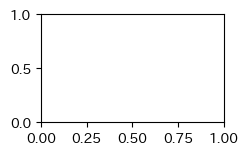

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
count = 1
fig = plt.figure(figsize=(25,10))
for col in cols:
    for score in sorted(y_train[col].unique()):
        ax = fig.add_subplot(6, 9, count)
        print(col, score)
        data = pd.concat([y_train[col], pred[col]], axis=1)
        data.columns = ["true", "pred"]
        sns.distplot(data[data["true"]==score].pred, ax = ax, kde=False);
        ax.set_xlabel(score);
        ax.set_xlim([1,5]);
        ax.set_title(col+str(score));
        plt.tight_layout()
        fig.show();
        count += 1

In [15]:
preds = [keras1_pred, keras2_pred, keras3_pred, keras4_pred, lgb1_pred, lgb2_pred]
pred = pd.DataFrame(np.mean(np.array(preds), axis=0), columns=cols, index=X_test_idx)
pred

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
text_id,,,,,,
0000C359D63E,2.767483,2.733454,2.969960,2.808294,2.716757,2.652545
000BAD50D026,3.038738,2.872625,3.037558,2.952971,2.719184,2.952540
00367BB2546B,3.365481,3.267979,3.486429,3.339178,3.286980,3.294214


In [86]:
pred.to_csv("submission.csv", index=True)